## 라이브러리 및 함수 선언

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None

2022-10-12 22:58:37.467935: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def weighted_mape(y_true, y_pred):
    tot = tf.reduce_sum(y_true)
    # 텐서 안의 값이 지정된 범위를 넘지 않게 해줌
    tot = tf.clip_by_value(tot, clip_value_min=0.01, clip_value_max=10000000000000) 
    wmape = tf.realdiv(tf.reduce_sum(tf.abs(tf.subtract(y_true,y_pred))), tot)*100
    
    return wmape

In [3]:
def mape(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

## 학습 데이터셋 불러오기

In [4]:
with h5py.File('../dataset/train_test_data.hdf5', 'r') as hf:
    X_train = hf['x_train'][:]
    Y_train = hf['y_train'][:]
    
    X_test = hf['x_test'][:]
    Y_test = hf['y_test'][:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1003363, 107), (1003363,), (251087, 107), (251087,))

## 모델 정의

In [5]:
def flow_prediction_model(x_size, y_size, learning_rate, dropout_ratio, epsilon):
    model = Sequential()
    
    model.add(Dense(512, activation='relu', input_shape=(x_size, ), kernel_initializer='RandomNormal'))
    Dropout(dropout_ratio)
    model.add(Dense(256, activation='relu'))
    Dropout(dropout_ratio)
    model.add(Dense(128, activation='relu'))
    Dropout(dropout_ratio)
    model.add(Dense(64, activation='relu'))
    Dropout(dropout_ratio)
    model.add(Dense(32, activation='relu'))
    Dropout(dropout_ratio)
    model.add(Dense(16, activation='relu'))
    Dropout(dropout_ratio)
    model.add(Dense(8, activation='relu'))
    Dropout(dropout_ratio)
    model.add(Dense(y_size))
    
    model.compile(loss=weighted_mape,
                  optimizer=Adam(learning_rate=learning_rate, epsilon=epsilon),
                  metrics=['mae'])
    
    return model

In [6]:
# Hyperparameter
learning_rate = 0.0001
dropout_ratio = 0.3
epsilon = 0.001  # Batch normalization
batch_size = 64

model = flow_prediction_model(x_size=X_train.shape[1], y_size=1, learning_rate=learning_rate,
                              dropout_ratio=dropout_ratio, epsilon=epsilon)
model.summary()

2022-10-12 22:58:48.066339: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-10-12 22:58:48.080927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 22:58:48.081795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:06.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-10-12 22:58:48.081971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 22:58:48.082785: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               55296     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1

## 모델 가중치 저장 체크포인트 생성

In [7]:
mcp_save = ModelCheckpoint("../weight/flow_prediction.h5", save_best_only=True, monitor="val_mae", mode="min")

## 모델 학습

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True, random_state=1004)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((802690, 107), (200673, 107), (802690,), (200673,))

In [9]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=100, verbose=1, validation_data=(X_val, Y_val), 
                    callbacks=[mcp_save], shuffle=True)

Epoch 1/100


2022-10-12 22:59:05.514659: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


12543/12543 [==============================] - 30s 2ms/step - loss: 4.8244 - mae: 226.1011 - val_loss: 3.8429 - val_mae: 179.6340
Epoch 2/100
12543/12543 [==============================] - 30s 2ms/step - loss: 3.8676 - mae: 180.8117 - val_loss: 4.1710 - val_mae: 195.5255
Epoch 3/100
12543/12543 [==============================] - 31s 2ms/step - loss: 3.6839 - mae: 172.2154 - val_loss: 3.6951 - val_mae: 172.6531
Epoch 4/100
12543/12543 [==============================] - 30s 2ms/step - loss: 3.5826 - mae: 167.3220 - val_loss: 4.5161 - val_mae: 211.4634
Epoch 5/100
12543/12543 [==============================] - 31s 2ms/step - loss: 3.4803 - mae: 162.6556 - val_loss: 3.4240 - val_mae: 160.2094
Epoch 6/100
12543/12543 [==============================] - 30s 2ms/step - loss: 3.4146 - mae: 159.5312 - val_loss: 3.3892 - val_mae: 158.4706
Epoch 7/100
12543/12543 [==============================] - 31s 2ms/step - loss: 3.3735 - mae: 157.6137 - val_loss: 3.7576 - val_mae: 175.9906
Epoch 8/100
12543/

12543/12543 [==============================] - 29s 2ms/step - loss: 2.9317 - mae: 136.9746 - val_loss: 2.9401 - val_mae: 137.4420
Epoch 59/100
12543/12543 [==============================] - 29s 2ms/step - loss: 2.9280 - mae: 136.7290 - val_loss: 3.1189 - val_mae: 145.7558
Epoch 60/100
12543/12543 [==============================] - 29s 2ms/step - loss: 2.9238 - mae: 136.5243 - val_loss: 3.0284 - val_mae: 141.5741
Epoch 61/100
12543/12543 [==============================] - 29s 2ms/step - loss: 2.9212 - mae: 136.3964 - val_loss: 2.9142 - val_mae: 136.2483
Epoch 62/100
12543/12543 [==============================] - 29s 2ms/step - loss: 2.9180 - mae: 136.2332 - val_loss: 2.9704 - val_mae: 138.8673
Epoch 63/100
12543/12543 [==============================] - 28s 2ms/step - loss: 2.9122 - mae: 135.9646 - val_loss: 3.0552 - val_mae: 142.9100
Epoch 64/100
12543/12543 [==============================] - 29s 2ms/step - loss: 2.9109 - mae: 135.9276 - val_loss: 2.9854 - val_mae: 139.6285
Epoch 65/100

In [10]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    plt.rc('font', size=7)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mae'])
    plt.plot(h['val_mae'])
    plt.title('Training vs Validation mae')
    plt.ylabel('mae')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

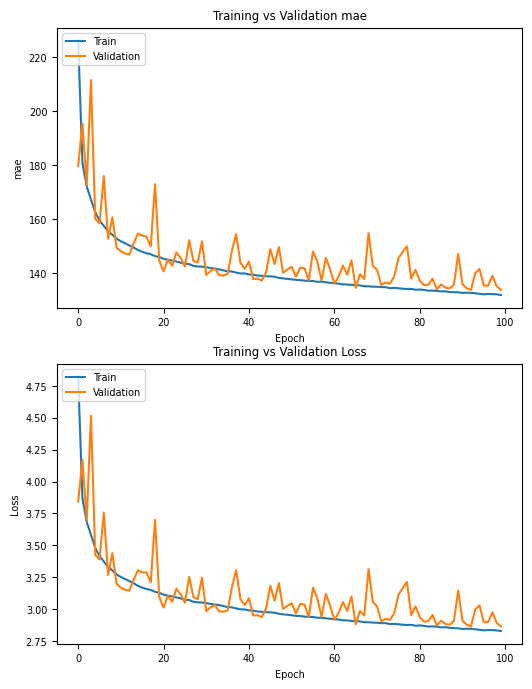

In [11]:
plot_hist(history.history, xsize=6, ysize=8)

## 모델 불러오기

In [12]:
model_2 = load_model('../weight/flow_prediction.h5', custom_objects={'weighted_mape': weighted_mape})

## 모델 성능 평가 (Mean Absolute Percentage Error)

In [13]:
predictions = model_2.predict(X_test).reshape(-1)
predictions

array([701.7408 , 642.4197 , 612.8004 , ..., 418.61255, 375.94113,
       329.70374], dtype=float32)

In [14]:
flow_prediction_mape = mape(Y_test, predictions)

print("음원 흐름 예측 모델 MAPE: {:.3f}".format(flow_prediction_mape))

음원 흐름 예측 모델 MAPE: 3.883
